In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [3]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Added color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Set directories for training and test datasets
train_dir = '/Users/GaryKong/Real_AI_SD_LD_Dataset/train/'  
test_dir = '/Users/GaryKong/Real_AI_SD_LD_Dataset/test'      

In [5]:
# Debugging: Check if the directories exist
import os 
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

Train directory exists: True
Test directory exists: True


In [6]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

In [7]:
# Print class mapping
print("Class to idx mapping:", train_dataset.class_to_idx)

Class to idx mapping: {'AI_LD_impressionism': 0, 'AI_SD_impressionism': 1, 'impressionism': 2}


In [ ]:
# Create data loaders 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Displaying first batch of images:


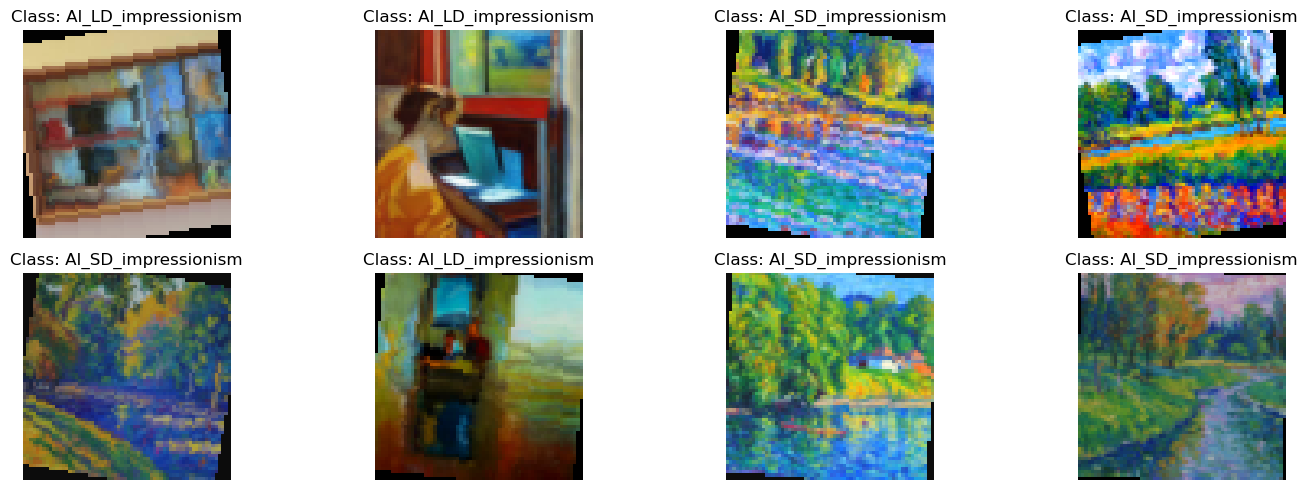

In [9]:
# Function to show images
def imshow_batch(images, labels, class_to_idx):
    plt.figure(figsize=(15, 5))
    
    # Create inverse mapping of class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    # Denormalize the images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    images = images * std + mean  # denormalize
    images = torch.clamp(images, 0, 1)  # clamp to [0,1]
    
    # Show images
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(f'Class: {idx_to_class[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch of training data and show it
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("\nDisplaying first batch of images:")
imshow_batch(images, labels, train_dataset.class_to_idx)

In [10]:
# Modified CNN architecture for 3-class classification
class UkiyoeCNN(nn.Module):
    def __init__(self, num_classes=3):  # Changed to 3 classes
        super(UkiyoeCNN, self).__init__()
        
        self.features = nn.Sequential(
            # First convolution block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second convolution block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third convolution block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth convolution block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer changed to 3 classes
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Testing phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = [0] * 3
        class_total = [0] * 3
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Per-class accuracy
                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print per-class accuracy
        for i in range(3):
            if class_total[i] > 0:
                class_acc = 100 * class_correct[i] / class_total[i]
                print(f'Accuracy of class {i}: {class_acc:.2f}%')
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_impressionism_classifier.pth')
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        print(f'Best Test Acc: {best_acc:.2f}%')
        print('-' * 60)
    
    return train_losses, test_losses, train_accuracies, test_accuracies


In [12]:
# Initialize model, loss function, and optimizer
model = UkiyoeCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [13]:
# Train the model
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10
)

Epoch 1/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 80.30%
Accuracy of class 1: 99.90%
Accuracy of class 2: 99.70%
Epoch 1/10:
Train Loss: 0.2378, Train Acc: 91.80%
Test Loss: 0.2765, Test Acc: 93.30%
Best Test Acc: 93.30%
------------------------------------------------------------


Epoch 2/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 85.60%
Accuracy of class 1: 99.60%
Accuracy of class 2: 99.70%
Epoch 2/10:
Train Loss: 0.1306, Train Acc: 95.61%
Test Loss: 0.2028, Test Acc: 94.97%
Best Test Acc: 94.97%
------------------------------------------------------------


Epoch 3/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 84.40%
Accuracy of class 1: 100.00%
Accuracy of class 2: 99.40%
Epoch 3/10:
Train Loss: 0.1420, Train Acc: 95.49%
Test Loss: 0.3153, Test Acc: 94.60%
Best Test Acc: 94.97%
------------------------------------------------------------


Epoch 4/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 91.10%
Accuracy of class 1: 99.80%
Accuracy of class 2: 99.00%
Epoch 4/10:
Train Loss: 0.1111, Train Acc: 96.59%
Test Loss: 0.1563, Test Acc: 96.63%
Best Test Acc: 96.63%
------------------------------------------------------------


Epoch 5/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 94.40%
Accuracy of class 1: 99.50%
Accuracy of class 2: 98.90%
Epoch 5/10:
Train Loss: 0.1021, Train Acc: 96.66%
Test Loss: 0.1002, Test Acc: 97.60%
Best Test Acc: 97.60%
------------------------------------------------------------


Epoch 6/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 98.40%
Accuracy of class 1: 98.80%
Accuracy of class 2: 98.10%
Epoch 6/10:
Train Loss: 0.0911, Train Acc: 97.10%
Test Loss: 0.0650, Test Acc: 98.43%
Best Test Acc: 98.43%
------------------------------------------------------------


Epoch 7/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 91.40%
Accuracy of class 1: 100.00%
Accuracy of class 2: 99.50%
Epoch 7/10:
Train Loss: 0.0894, Train Acc: 97.16%
Test Loss: 0.1324, Test Acc: 96.97%
Best Test Acc: 98.43%
------------------------------------------------------------


Epoch 8/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 79.10%
Accuracy of class 1: 99.70%
Accuracy of class 2: 99.60%
Epoch 8/10:
Train Loss: 0.0716, Train Acc: 97.60%
Test Loss: 0.4234, Test Acc: 92.80%
Best Test Acc: 98.43%
------------------------------------------------------------


Epoch 9/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 98.80%
Accuracy of class 1: 99.20%
Accuracy of class 2: 97.40%
Epoch 9/10:
Train Loss: 0.0769, Train Acc: 97.53%
Test Loss: 0.0664, Test Acc: 98.47%
Best Test Acc: 98.47%
------------------------------------------------------------


Epoch 10/10:   0%|          | 0/488 [00:00<?, ?it/s]

Accuracy of class 0: 96.00%
Accuracy of class 1: 99.50%
Accuracy of class 2: 98.20%
Epoch 10/10:
Train Loss: 0.0916, Train Acc: 97.10%
Test Loss: 0.1518, Test Acc: 97.90%
Best Test Acc: 98.47%
------------------------------------------------------------


In [ ]:
# Plot training and testing curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Testing Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# Save the final model
torch.save(model.state_dict(), 'final_ukiyoe_classifier.pth')